In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import os
import torch
from torch import nn
import copy

fn = os.path.join('..', 'data', 'BP_data.pkl')
df = pd.read_pickle(fn)
df = df[df['DiastolicP']>30]  # trow out outlier
df = df.reset_index(drop = True)

print(df)
print(df.columns)

    SubjectID Condition  Age Gender  Height  Weight  SystolicP  DiastolicP  \
0    c010510d        BN   63      M   170.0    66.1      161.0        82.5   
1    c010510d        BN   63      M   170.0    66.1      162.2        82.8   
2    c010510d        AN   63      M   170.0    66.1      155.2        80.3   
3    c010510d        AN   63      M   170.0    66.1      157.3        79.3   
4    c010610d        BN   49      M   175.2    82.4      129.5        72.6   
..        ...       ...  ...    ...     ...     ...        ...         ...   
188  c121609d        BN   84      M   163.0    50.0      140.1        65.4   
189  c121609d        AN   84      M   163.0    50.0      133.8        64.2   
190  c122309d        BN   65      F   154.2    62.6      139.6        69.9   
191  c122309d        BN   65      F   154.2    62.6      140.2        69.3   
192  c122309d        AN   65      F   154.2    62.6      139.7        72.7   

     MeanP                                              CuffP  

In [135]:
def butter_filter(data, cutoff, fs, order=5, btype = 'low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=btype, analog=False)
    y = signal.filtfilt(b, a, data, method='gust' )
    return y

def hilbert_mag(x):
    signal2 = np.concatenate((x[::-1], x, x[::-1]))
    analytic_signal2 = signal.hilbert(signal2)
    amplitude_envelope = np.abs(analytic_signal2[len(x):2*len(x)])
    return amplitude_envelope

def moving_average(a, n=1000):
    # ret = np.cumsum(a, dtype=float)
    # ret[n:] = ret[n:] - ret[:-n]
    # return ret[n - 1:] / n

    x = np.linspace(-3, 3, n)
    v = np.exp(-(x/1)**2/2)
    #v = np.ones(n)

    y = np.convolve(a, v, mode='same')/np.sum(v)
    return y


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
    device = 'cuda'
else:
    print("No GPU available. Training will run on CPU.")
    device = 'cpu'

GPU: NVIDIA GeForce RTX 3070 is available.


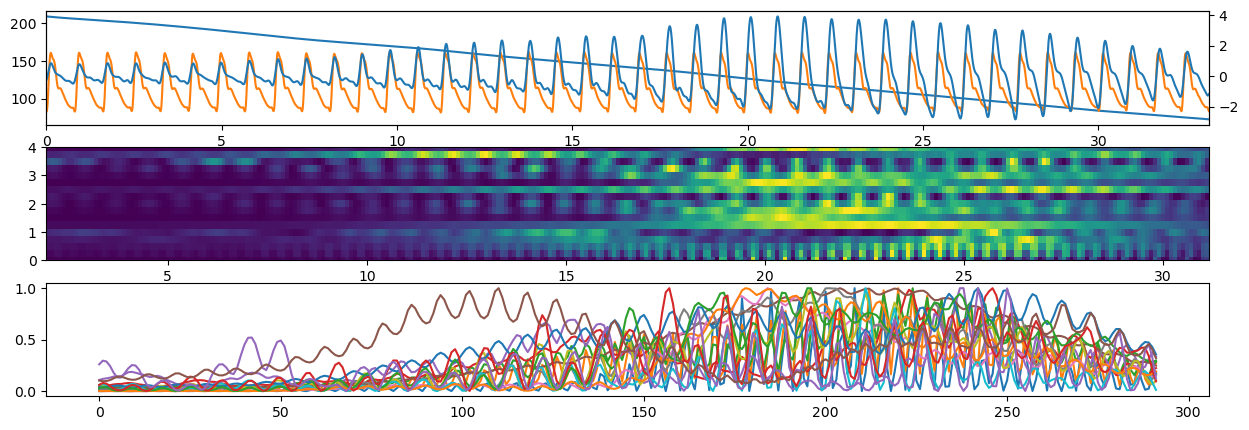

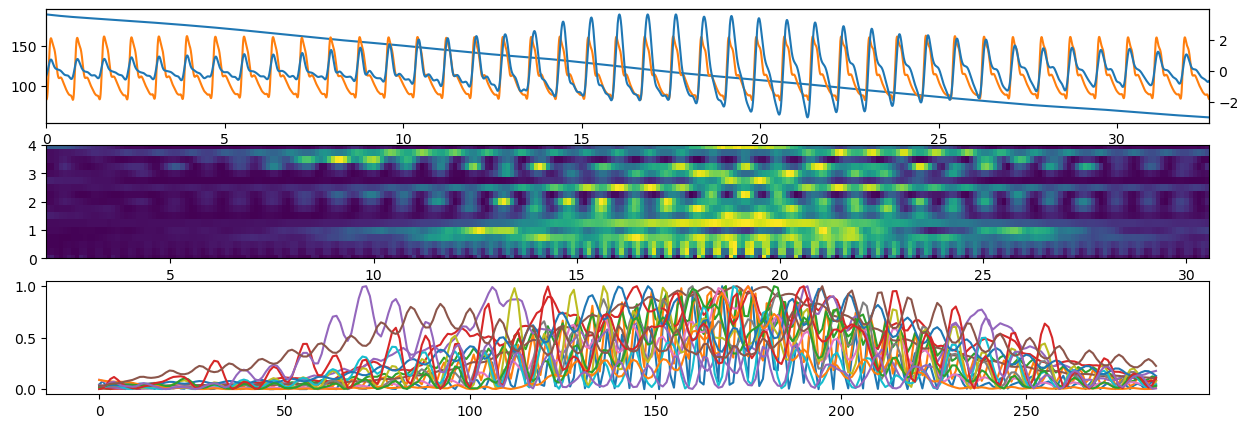

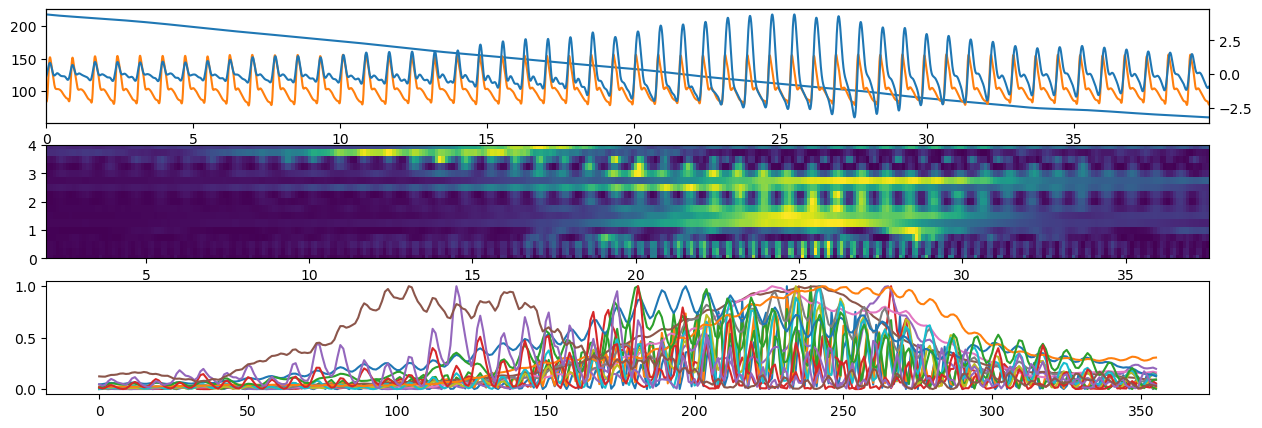

In [136]:
for i in range(3):

    fig, ax = plt.subplots(3, 1)

    fig.set_size_inches(15, 5)

    t = np.arange(0, len(df.loc[i, 'dc_cuff_pressure'])*1/500, 1/500)

    ax[0].plot(t, df.loc[i, 'dc_cuff_pressure'])
    ax[0].plot(t, df.loc[i, 'brachial_waveform'])
    ax[0].set_xlim(0, t[-1])
    ax2 = ax[0].twinx()
    ax2.plot(t, df.loc[i, 'cuff_pressure_oscillations'])

    f_spec, t_spec, Sxx = signal.spectrogram(df.loc[i, 'cuff_pressure_oscillations'], fs = 500, nperseg = 2000, noverlap=1950)

    ax[1].pcolormesh(t_spec, f_spec, Sxx/np.max(Sxx, axis = 1, keepdims=True), shading='auto')
    ax[1].set_ylim(0, 4)

    I = f_spec<4
    Sxx = Sxx[I, :]
    Sxx = Sxx/np.max(Sxx, axis = 1, keepdims=True)
    ax[2].plot(Sxx.T)

In [137]:
seq_length = 100
N_samples = len(df)
N_features = 3
N_targets = 3

XX = np.zeros((N_samples, seq_length, N_features), dtype = np.float32)
YY = np.zeros((N_samples, 1, N_targets), dtype = np.float32)

# def make_spectrogram(x):
#     f_spec, t_spec, Sxx = signal.spectrogram(df.loc[i, 'cuff_pressure_oscillations'], fs = 500, nperseg = 2000, noverlap=1950)
#     I = np.logical_and(f_spec<4, f_spec>0)
#     Sxx = Sxx[I, :]
#     Sxx = Sxx/np.max(Sxx, axis = 1, keepdims=True)
#     f_spec =f_spec[I]
#     print(Sxx.shape)
#     return f_spec, t_spec, Sxx



for i, idx in enumerate(df.index):
  
  
    dc = df.at[idx, 'dc_cuff_pressure']
    SP = df.at[idx, 'SystolicP']
    DP = df.at[idx, 'DiastolicP']
    MP = df.at[idx, 'MeanP']

    XX[i, :, 0] = df.at[idx, 'CuffP']
    XX[i, :, 1] = df.at[idx, 'Amplitude']
    XX[i, :, 2] = df.at[idx, 'Area']

    YY[i, 0, 0] = MP 
    YY[i, 0, 1] = DP
    YY[i, 0, 2] = SP




In [138]:
def normaize_data(XX, reverse = False, Xnorm = (-1, 1)):
    
    if reverse == True:
        XX = XX*(Xnorm[1]-Xnorm[0]) + Xnorm[0]

    else:
        minX = np.min(XX, axis = (0, 1), keepdims=True)
        maxX = np.max(XX, axis = (0, 1), keepdims=True)
        Xnorm = (minX, maxX)
        XX = (XX-Xnorm[0])/(Xnorm[1]-Xnorm[0])


    return XX, Xnorm

In [139]:
N_test = 30  # dont duplicate test data into training


def gen_synthetic_data(XX, YY, mag = 2.5, multiple = 2, N_test = N_test):
    print(XX.shape, YY.shape)
    for j in range(multiple):
        XX2 = XX[N_test:,:,:].copy()
        YY2 = YY[N_test:,:,:].copy()

        rand_offset = 2*mag*(np.random.rand(XX2.shape[0], 1, 1)-.5)

        XX2[:, :, [0]] = XX2[:, :, [0]] + rand_offset
        YY2[:, :, :] = YY2[:, :, :] + rand_offset

        XX = np.concatenate([XX, XX2], axis = 0)
        YY = np.concatenate([YY, YY2], axis = 0)
        print(XX.shape, YY.shape)
    return XX, YY


XX, YY = gen_synthetic_data(XX, YY)


(193, 100, 3) (193, 1, 3)
(356, 100, 3) (356, 1, 3)
(682, 100, 3) (682, 1, 3)


In [140]:
XX, Xnorm = normaize_data(XX)
YY, Ynorm = normaize_data(YY)

print(np.min(XX), np.max(XX))

0.0 1.0


In [141]:
XX = torch.tensor(XX, device=device)
YY = torch.tensor(YY, device=device)

print(XX.shape, YY.shape)

torch.Size([682, 100, 3]) torch.Size([682, 1, 3])


In [142]:

I_train = np.full(XX.shape[0], True)
I_train[:N_test] = False

XX_test = XX[~I_train, :, :]
XX_train = XX[I_train, :, :]
YY_test = YY[~I_train, :, :]
YY_train = YY[I_train, :, :]

print(XX_train.shape, YY_train.shape)
print(YY_test.shape, YY_test.shape)

torch.Size([652, 100, 3]) torch.Size([652, 1, 3])
torch.Size([30, 1, 3]) torch.Size([30, 1, 3])


In [143]:
class neural_network(nn.Module):
    def __init__(self, input_size , output_size, hidden_size = 10, num_layers = 2):
        super(neural_network,self).__init__()
        self.fc0 = nn.Linear(in_features=input_size,out_features=hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(in_features=2*hidden_size,out_features=output_size)  # *2 because bidirectional
        self.dropout = nn.Dropout(p = .1)

    def forward(self,x):
        output = x
        output = self.dropout(output)
        output = self.fc0(output)
        output = torch.relu(output)
        output = self.dropout(output)
        output,_status = self.lstm(output)
        output = output[:,[-1],:]
        output = self.dropout(output)
        output = self.fc1(torch.relu(output))
        return output




In [148]:
model = neural_network(input_size = N_features, output_size = N_targets)
model.to(device)
model.train()


optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)
loss = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',  factor=0.5, patience=100)

epochs = 10000

losses_train = []
losses_test = []
no_improvement_count = 0
loss_to_beat = 999999.0

model_best = copy.deepcopy(model)

for i in range(epochs):
        model.train()
        optimizer.zero_grad() 

        YY_pred_train = model(XX_train)

        loss_train = loss(YY_pred_train,YY_train)
        loss_train.backward()
        optimizer.step()

        with torch.no_grad():
                model.eval()
                YY_pred_test = model(XX_test)
                loss_test = loss(YY_pred_test,YY_test)
                scheduler.step(loss_test)

        if i%10 ==0:
                print(f'{i}, train loss = {loss_train:.4e}, test loss = {loss_test:.4e}, no improvement for epochs = {no_improvement_count}, lr = {scheduler.get_last_lr()[0]:.2e}')
        
        loss_train = loss_train.cpu().detach().numpy()
        loss_test = loss_test.cpu().detach().numpy()

        if loss_test < loss_to_beat:
                loss_to_beat = loss_test
                no_improvement_count = 0
                model_best = copy.deepcopy(model)
        else:
                no_improvement_count = no_improvement_count+1

        if no_improvement_count > 1000:  # early stopping
                print('early stopping activated')
                break

        losses_train.append(loss_train)
        losses_test.append(loss_test)

0, train loss = 2.9474e-01, test loss = 3.0426e-01, no improvement for epochs = 0, lr = 1.00e-03
10, train loss = 2.5234e-01, test loss = 2.6192e-01, no improvement for epochs = 0, lr = 1.00e-03
20, train loss = 2.1547e-01, test loss = 2.2448e-01, no improvement for epochs = 0, lr = 1.00e-03
30, train loss = 1.7822e-01, test loss = 1.8431e-01, no improvement for epochs = 0, lr = 1.00e-03
40, train loss = 1.3773e-01, test loss = 1.4016e-01, no improvement for epochs = 0, lr = 1.00e-03
50, train loss = 9.7612e-02, test loss = 9.3877e-02, no improvement for epochs = 0, lr = 1.00e-03
60, train loss = 6.4506e-02, test loss = 6.0116e-02, no improvement for epochs = 0, lr = 1.00e-03
70, train loss = 5.1640e-02, test loss = 4.2944e-02, no improvement for epochs = 0, lr = 1.00e-03
80, train loss = 4.8232e-02, test loss = 3.5430e-02, no improvement for epochs = 0, lr = 1.00e-03
90, train loss = 4.8379e-02, test loss = 3.2418e-02, no improvement for epochs = 0, lr = 1.00e-03
100, train loss = 4.5

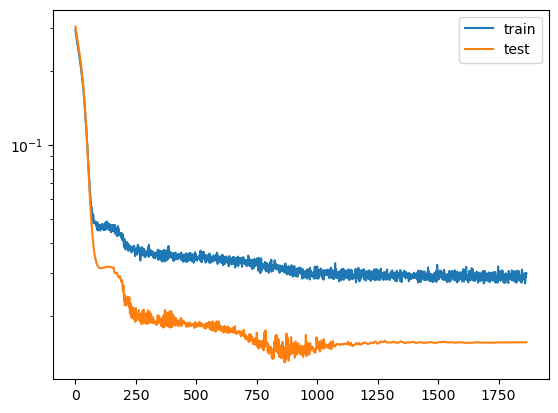

In [149]:
fig, ax = plt.subplots(1, 1)
ax.plot(losses_train, label = 'train')
ax.plot(losses_test, label = 'test')
ax.legend()
ax.set_yscale('log')

In [ ]:
model_best.lstm.flatten_parameters()
with torch.no_grad():
        model_best.eval()
        YY_pred_test = model_best(XX_test)
        YY_pred_train = model_best(XX_train)


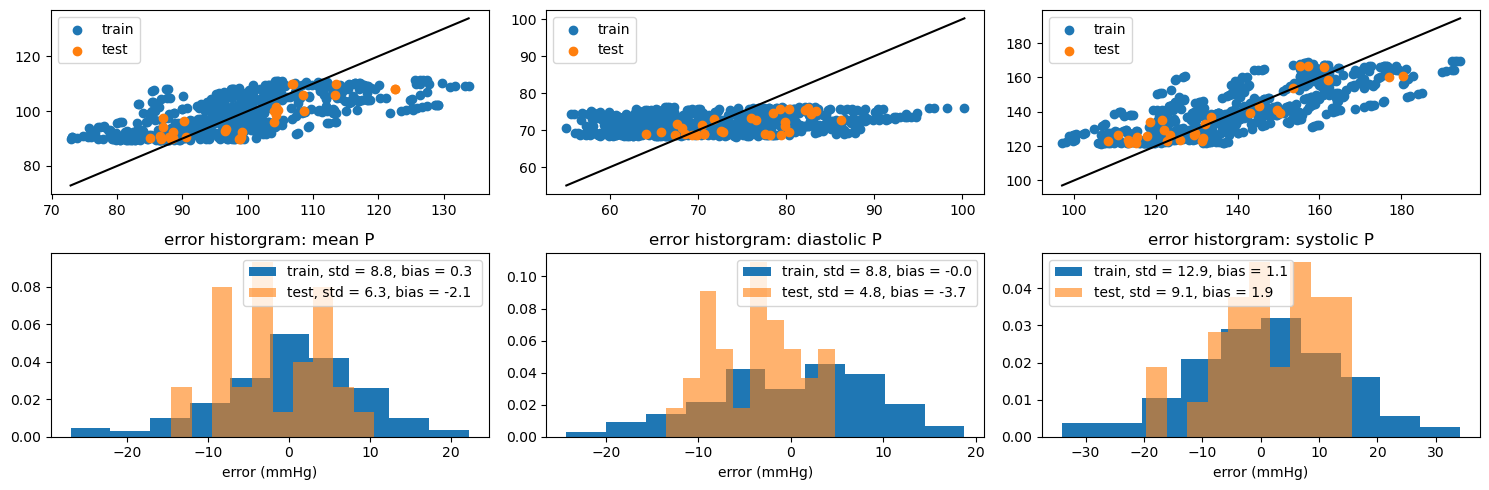

In [151]:

def t2n(x):
    return x.cpu().detach().numpy()


def prep_for_plotting(Y):
    Y = t2n(Y)
    Y, _ = normaize_data(Y, reverse = True, Xnorm = Ynorm)
    Y = Y.squeeze()
    return Y

ya_test = prep_for_plotting(YY_test)
yp_test= prep_for_plotting(YY_pred_test)

ya_train = prep_for_plotting(YY_train)
yp_train= prep_for_plotting(YY_pred_train)



def calculate_error(yp, ya):
    error = yp - ya
    std_error = np.std(error, axis = 0)
    bias_error = np.mean(error, axis = 0)

    return error, std_error, bias_error

error_train, std_error_train, bias_error_train = calculate_error(yp_train, ya_train)
error_test, std_error_test, bias_error_test = calculate_error(yp_test, ya_test)


targets = ['mean P', 'diastolic P', 'systolic P']
fig, ax = plt.subplots(2, N_targets)

for i in range(N_targets):


    ax[0,i].scatter(ya_train[:,i], yp_train[:,i], label = 'train')
    ax[0,i].scatter(ya_test[:,i], yp_test[:,i], label = 'test')
    ax[0,i].plot([np.min(ya_train[:,i]), np.max(ya_train[:,i])], [np.min(ya_train[:,i]), np.max(ya_train[:,i])], color = 'k')
    ax[0,i].legend()


    
    ax[1,i].hist(error_train[:, i], label = f'train, std = {std_error_train[i]:.1f}, bias = {bias_error_train[i]:.1f}', density = True, alpha = 1)
    ax[1,i].hist(error_test[:, i], label = f'test, std = {std_error_test[i]:.1f}, bias = {bias_error_test[i]:.1f} ', density = True, alpha = .6)
    ax[1,i].set_xlabel('error (mmHg)')
    ax[1,i].set_title(f'error historgram: {targets[i]}')
    ax[1,i].legend()


fig.set_size_inches(15, 5)
fig.tight_layout()